In [1]:
%%capture
pip install git+https://github.com/guillermo-jimenez/sak.git

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sak
from functools import partial
import math
import scipy as sp
import skimage
from typing import List
import numpy as np

In [3]:
with open('all_points_may_2024.pkl', 'rb') as file:
    data = pickle.load(file)

# METADATA CLEANING

In [4]:
# -----------------------------------------------------------------------------
# 1) build metadata DataFrame and index it by patient_id
# -----------------------------------------------------------------------------
meta = []
for pid, patient in data.items():
    meta.append({
        'patient_id':    pid,
        'sex':           patient['Sex'][0],
        'hta':           patient['HTA'][0],
        'age':           patient['Age'][0],
        'pvc_transition':patient['PVC_transition'][0],
        'soo_chamber':   patient['SOO_chamber'][0],
        'height':        patient['Height'][0],
        'weight':        patient['Weight'][0],
        'bmi':           patient['BMI'][0],
        'dm':            patient['DM'][0],
        'dlp':           patient['DLP'][0],
        'smoker':        patient['Smoker'][0],
        'copd':          patient['COPD'][0],
        'sleep_apnea':   patient['Sleep_apnea'][0],
        'clinical_score':patient['CLINICAL_SCORE'][0],
        'soo':           patient['SOO'][0],
        'otorigin':      patient['OTorigin'][0],
    })
meta_df = pd.DataFrame(meta).set_index('patient_id')

In [5]:
meta_df['smoker']      = meta_df['smoker'].map({'Yes':1,'No':0}).fillna(-1)
meta_df['dm']          = meta_df['dm'].map({'Yes':1,'No':0}).fillna(-1)
meta_df['hta']         = meta_df['hta'].map({'Yes':1,'No':0}).fillna(-1)
meta_df['dlp']         = meta_df['dlp'].map({'Yes':1,'No':0}).fillna(-1)
meta_df['copd']        = meta_df['copd'].map({'Yes':1,'No':0}).fillna(-1)
meta_df['sleep_apnea'] = meta_df['sleep_apnea'].map({'Yes':1,'No':0}).fillna(-1)
meta_df['sex']         = meta_df['sex'].map({'Female':1,'Male':0}).fillna(-1)

In [6]:
# compute the median once and fill:
median_age = meta_df['age'].median()
meta_df['age'] = meta_df['age'].fillna(median_age)

In [ ]:
# 1) Compute the medians
w_med = meta_df['weight'].median()
h_med = meta_df['height'].median()

# Boolean masks
mask_w_na = meta_df['weight'].isna()
mask_h_na = meta_df['height'].isna()
mask_b_na = meta_df['bmi'].isna()

# 2) If weight & BMI known but height missing → compute height
m = mask_h_na & (~mask_w_na) & (~mask_b_na)
meta_df.loc[m, 'height'] = np.sqrt(
    meta_df.loc[m, 'weight'] / meta_df.loc[m, 'bmi']
) * 100

# 3) If height & BMI known but weight missing → compute weight
m = mask_w_na & (~mask_h_na) & (~mask_b_na)
meta_df.loc[m, 'weight'] = (
    meta_df.loc[m, 'bmi']
    * (meta_df.loc[m, 'height'] / 100) ** 2
)

# 4) For any remaining missing weight or height (including the “both missing” case),
#    impute with the respective medians
meta_df['weight'] = meta_df['weight'].fillna(w_med)
meta_df['height'] = meta_df['height'].fillna(h_med)

# 5) Now compute BMI wherever it’s still missing
m = meta_df['bmi'].isna()
meta_df.loc[m, 'bmi'] = (
    meta_df.loc[m, 'weight']
    / ( (meta_df.loc[m, 'height'] / 100) ** 2 )
)

In [8]:
# for the pvc_transition we drop the rows that have missing values
meta_df = meta_df.dropna(subset=['pvc_transition'])
meta_df = meta_df.dropna(subset=['otorigin']) #if we do not have ground truth, we cannot test

In [9]:
meta_df = meta_df[meta_df['otorigin'] == 1]


In [ ]:
# map from raw soo/soo_chamber/otorigin features to simplified soo with the labels excel
template     = pd.read_excel('labels_FontiersUnsupervised.xlsx', sheet_name='Hoja2')
Specific_SOO = meta_df['soo'].copy()

#Create a list with the specific SOO depending on the original label
Simplified_SOO = []
for SOO in Specific_SOO:
    idxs = template.index[template['SOO'] == SOO].tolist()
    if len(idxs) != 0:
        Simplified_SOO.append(template.iloc[idxs[0]]['Simplified'])
    else:
        Simplified_SOO.append('-') #Not recognized or nor annotated

meta_df['Simplified'] = Simplified_SOO

#Cases per origin (There are few cases from origins in the AoC, such as LCC or RCC)
counter = {i:Simplified_SOO.count(i) for i in Simplified_SOO}
print(counter)

{'RVOTFREEWALL': 31, 'RCC': 9, 'RVOTSEPTUM': 47, 'LCC': 7, 'COMMISURE': 15, 'LVOTSUBVALVULAR': 2, '-': 1}


In [ ]:
# -----------------------------------------------------------------------------
# 2) build an ECG DataFrame: one row per (patient, region, point) with a 12×T array
# -----------------------------------------------------------------------------
rows = []
for pid, patient in data.items():
    structs = patient.get('Structures')
    if not structs:
        continue
    for region, pts in structs.items():
        if pts is None:
            continue
        for pt, leads in pts.items():
            # stack the 12 standard leads into a (12, T) array
            arr = np.stack([leads[L] for L in
                            ['I','II','III','AVR','AVL','AVF',
                             'V1','V2','V3','V4','V5','V6']])
            rows.append({
                'patient': pid,
                'region':  region,
                'point':   pt,
                'ecg':     arr
            })
ecg_df = pd.DataFrame(rows)

# -----------------------------------------------------------------------------
# 3) merge ECG rows with metadata via meta_df’s index
# -----------------------------------------------------------------------------
df = ecg_df.merge(
    meta_df,
    left_on     = 'patient',
    right_index = True,
    how         = 'inner'
)

print(df.info())



<class 'pandas.core.frame.DataFrame'>
Index: 13870 entries, 204 to 29152
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient         13870 non-null  object 
 1   region          13870 non-null  object 
 2   point           13870 non-null  object 
 3   ecg             13870 non-null  object 
 4   sex             13870 non-null  float64
 5   hta             13870 non-null  float64
 6   age             13870 non-null  float64
 7   pvc_transition  13870 non-null  object 
 8   soo_chamber     13870 non-null  object 
 9   height          13870 non-null  float64
 10  weight          13870 non-null  float64
 11  bmi             13870 non-null  float64
 12  dm              13870 non-null  float64
 13  dlp             13870 non-null  float64
 14  smoker          13870 non-null  float64
 15  copd            13870 non-null  float64
 16  sleep_apnea     13870 non-null  float64
 17  clinical_score  13553 non-null  fl

In [12]:
pip install openpyxl

python(10862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


# SEGMENTATION OF ECGS

In [ ]:
import os
model_dir = r"C:\Users\Lluis\Downloads\modelos\modelos"
model_files = [f"model.{i}" for i in range(1, 6)]

model_paths = [os.path.join(model_dir, f) for f in model_files]
models_ECG = [torch.load(path, map_location="cpu") for path in model_paths]

print("Models loaded correctly from local directory.")

The predict_ecg function is a segmentation pipeline for ECG signals. It detects P waves, QRS complexes and T waves across all leads of an ECG.

In [13]:
def predict_ecg(ecg: np.ndarray, fs: float, model: List[torch.nn.Module],
                window_size: int = 2048, stride: int = 256, threshold_ensemble: float = 0.5,
                thr_dice=0.9, percentile=95, ptg_voting = 0.5, batch_size = 16,
                normalize=True, norm_threshold: float = 1e-6, filter = True) -> np.ndarray:
    """This function is used to delineate an ECG recording of arbitrary size ('ecg' variable, SAMPLES x LEADS)
    and to obtain the fiducials for the P, QRS and T segments as a binary mask of shape 3 x SAMPLES.

    Inputs:
    ecg                <- some array, e.g. shape 198484 x 12
    fs                 <- sampling frequency, e.g. 1000Hz. Will downsample to 250Hz for the AI model to work
    model              <- list of segmentation models for the ensemble
    window_size        <- the "chunk" size that will be processed at a time of the input ecg (e.g., in the example,
                          2048 samples out of the 198484 samples of the ECG)
    stride             <- the "stride" parameter allows for some overlap between the windows of the window_size
    threshold_ensemble <- Percentage of voting for the AI ensemble [0-1]
    thr_dice           <- Threshold for considering each sample as positive according to the Dice score
    percentile         <- Percentile for the amplitude normalization
    ptg_voting         <- Threshold for considering each sample as positive according to the Dice score
    batch_size         <- Number of windows that fit in the batch
    normalize          <- Boolean to indicate whether the ECG has to be normalized. In general, set this to True
                          always, as the ECGs must have the amplitude of a normal sinus rhythm around amplitude of
                          "1" to work, as that was the preprocessing for model training. Only change if a
                          comparable pre-processing is performed
    norm_threshold     <- Threshold for the normalization, to avoid passing baseline wander or noise as signal
    filter             <- Filter the signal with a band-pass filter in [0.5-125] Hz
    """
    # Preprocess signal
    ecg = np.copy(ecg).squeeze()
    if ecg.ndim == 0:
        return np.array([])
    elif ecg.ndim == 1:
        ecg = ecg[:,None]
    elif ecg.ndim == 2:
        if ecg.shape[0] < ecg.shape[1]:
            ecg = ecg.T
    else:
        raise ValueError("2 dims max allowed")
    ecg_250 = sak.signal.interpolate.interp1d(ecg,round(ecg.shape[0]*250/fs),axis=0)


    # Pad if necessary
    if ecg_250.shape[0] < window_size:
        padding = math.ceil(ecg_250.shape[0]/window_size)*window_size-ecg_250.shape[0]
        ecg_250 = np.pad(ecg_250,((0,padding),(0,0)),mode='edge')
    if (ecg_250.shape[0]-window_size)%stride != 0:
        padding = math.ceil((ecg_250.shape[0]-window_size)/stride)*stride-(ecg_250.shape[0]%window_size)
        ecg_250 = np.pad(ecg_250,((0,padding),(0,0)),mode='edge')

    # Get dimensions
    N,L = ecg_250.shape

    # (Optional) Normalize amplitudes
    if normalize:
        # Get ecg_250 when it's not flat zero
        norm_signal = ecg_250[np.all(np.abs(np.diff(ecg_250,axis=0,append=0)) >= norm_threshold,axis=1),:]

        # High pass filter normalized ecg_250 to avoid issues with baseline wander
        norm_signal = sp.signal.filtfilt(*sp.signal.butter(2, 0.5/250., 'high'),norm_signal, axis=0)

        # Compute amplitude for those segments
        amplitude = np.array(sak.signal.moving_lambda(
            norm_signal,
            256,
            partial(sak.signal.amplitude,axis=0),
            axis=0
        ))
        amplitude = amplitude[np.all(amplitude > norm_threshold,axis=1),]
        amplitude = np.percentile(amplitude, percentile, axis=0)

        # Apply normalization
        ecg_250 = ecg_250/amplitude[None,:]

    # (Optional) Filter ecg_250
    if filter:
        ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2,   0.5/250., 'high'),ecg_250,axis=0)
        ecg_250 = sp.signal.filtfilt(*sp.signal.butter(2, 125.0/250.,  'low'),ecg_250,axis=0)
        ecg_250 = sp.signal.lfilter(*sp.signal.iirnotch(50,20.0,250.),ecg_250,axis=0)
        ecg_250 = sp.signal.lfilter(*sp.signal.iirnotch(60,20.0,250.),ecg_250,axis=0)

    # Avoid issues with negative strides due to filtering:
    if np.any(np.array(ecg_250.strides) < 0):
        ecg_250 = ecg_250.copy()

    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(ecg_250,(window_size,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=int)

    # Check device for segmentation
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Compute segmentation for all leads independently
    with torch.no_grad():
        if isinstance(model,list):
            for m in model:
                m = m.to(device)
                for i in range(0,windowed_signal.shape[0],batch_size):
                    inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).float().to(device)}
                    outputs = m(inputs)["sigmoid"].cpu().detach().numpy()
                    windowed_mask[i:i+batch_size] += outputs > thr_dice
            windowed_mask = windowed_mask >= len(model)*threshold_ensemble
        else:
            model = model.to(device)
            for i in range(0,windowed_signal.shape[0],batch_size):
                inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).to(device).float()}
                outputs = model(inputs)["sigmoid"].cpu().QAdetach().numpy()
                windowed_mask[i:i+batch_size] = outputs > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((N), dtype=int)
    segmentation_250 = np.zeros((3,N))

    # Iterate over windows
    for i in range(0,windowed_mask.shape[0],L):
        counter[(i//L)*stride:(i//L)*stride+window_size] += 1
        segmentation_250[:,(i//L)*stride:(i//L)*stride+window_size] += windowed_mask[i:i+L].sum(0)
    segmentation_250 = ((segmentation_250/counter) >= (ecg_250.shape[-1]*ptg_voting))

    # Correct padding
    segmentation_250 = segmentation_250[:,:-padding]

    # Interpolate back to original sampling frequency
    segmentation     = sak.signal.interpolate.interp1d(segmentation_250,ecg.shape[0],axis=-1,kind="nearest")

    return segmentation


This function is designed to segment the first and last QRS complex in lead V1 of each ECG signal stored.

In [ ]:
import time

def segment_first_and_last_qrs_interval_v1(df_target, models_ECG, fs=1000, verbose=True):
    results = []
    total = len(df_target)
    start_time = time.time()

    for i, row in df_target.iterrows():
        try:
            ecg = row["ecg"]
            v1 = ecg[6]

            # Resample to 250 Hz
            N = len(v1)
            fs_new = 250
            N_new = int(N * fs_new / fs)
            t_original = np.arange(N) / fs
            t_new = np.linspace(0, (N - 1) / fs, N_new)

            f_interp = interpolate.interp1d(t_original, v1, kind='linear')
            ecg_250 = f_interp(t_new)

            # low-pass and high-pass filtering
            b_high, a_high = butter(2, 0.5 / fs_new, 'high')
            ecg_250 = filtfilt(b_high, a_high, ecg_250)
            b_low, a_low = butter(2, 100.0 / fs_new, 'low')
            ecg_250 = filtfilt(b_low, a_low, ecg_250)

            # V1 segmentation
            segmentation_250 = predict_ecg(ecg_250, fs_new, models_ECG, normalize=True, filter=False)
            qrs_mask_250 = segmentation_250[1].astype(int)

            # transition detection
            transitions = np.diff(qrs_mask_250)
            start_indices = np.where(transitions == 1)[0] + 1
            end_indices = np.where(transitions == -1)[0] + 1

            if len(start_indices) < 2 or len(end_indices) < 2:
                if verbose:
                    print(f"There are no sufficient QRS detected in df_target.iloc[{i}]")
                continue
            if end_indices[-1] < start_indices[-1]:
                end_indices = np.append(end_indices, len(qrs_mask_250))

            # first QRS
            start_first = start_indices[0]
            end_first_candidates = end_indices[end_indices > start_first]
            if len(end_first_candidates) == 0:
                continue
            end_first = end_first_candidates[0]

            # last QRS
            start_last = start_indices[-1]
            end_last_candidates = end_indices[end_indices > start_last]
            if len(end_last_candidates) == 0:
                continue
            end_last = end_last_candidates[0]

            if start_first == start_last and end_first == end_last:
                if verbose:
                    print(f"Frist and last QRS are the same in df_target.iloc[{i}]")
                continue

            # Resample to 1000 Hz
            factor = fs / fs_new
            start_first = int(round(start_first * factor))
            end_first = int(round(end_first * factor))
            start_last = int(round(start_last * factor))
            end_last = int(round(end_last * factor))

            intervals = [(start_first, end_first), (start_last, end_last)]

            # Masks at 1000 Hz
            qrs_mask = np.zeros(N, dtype=int)
            mask_first = np.copy(qrs_mask)
            mask_last = np.copy(qrs_mask)
            mask_first[start_first:end_first] = 1
            mask_last[start_last:end_last] = 1

            results.append({
                "idx": i,
                "masks": [mask_first, mask_last],
                "v1": v1,
                "intervals": intervals
            })

        except Exception as e:
            if verbose:
                print(f"Error in df_target.iloc[{i}]: {e}")
            continue

        # Show progress
        if verbose and i % 50 == 0:
            elapsed = time.time() - start_time
            pct = 100 * (i + 1) / total
            est_total = elapsed / (i + 1) * total
            eta = est_total - elapsed
            print(f"[{i + 1}/{total}] {pct:.1f}% compleated - ETA: {eta/60:.1f} min")

    total_time = time.time() - start_time
    print(f"Segmentation compleated in {total_time/60:.1f} minutes ({len(results)} valid results).")

    return results


In [ ]:
segmentaciones2 = segment_first_and_last_qrs_interval_v1(df, models_ECG, fs=1000, verbose=True)

we store the result segmentations in segmentaciones2qrs.pkl

In [ ]:
# Cambia la ruta si lo tienes en otra carpeta
with open("segmentaciones2qrs.pkl", "rb") as f:
    segmentaciones2 = pickle.load(f)

print(f" {len(segmentaciones2)} segmentations loaded.")

In this code we combine the two qrs masks and check that the intervals match what's seen in the V1 lead.

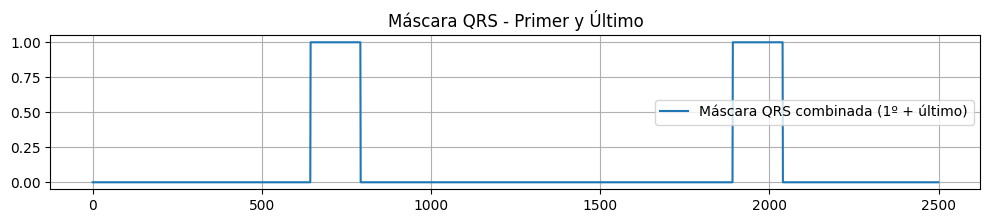

In [ ]:
seg = next(s for s in segmentaciones2 if s["idx"] == 391)
qrs_mask = seg["masks"][0] + seg["masks"][1]

plt.figure(figsize=(12, 2))
plt.plot(qrs_mask, label="Mask QRS combined (first and last)")
plt.title("Mask QRS - First and last")
plt.legend()
plt.grid(True)
plt.show()

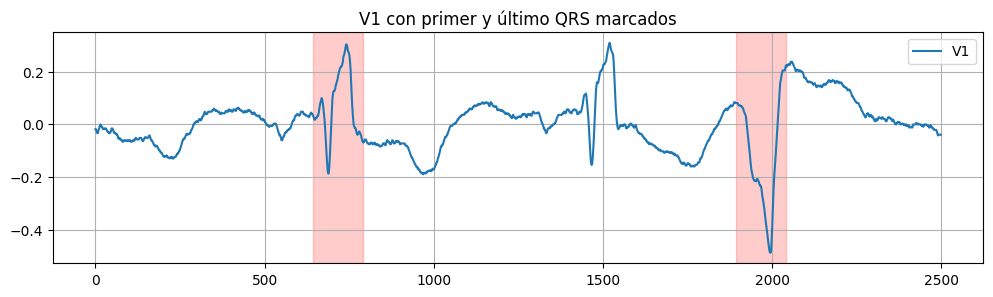

In [ ]:
seg = next(s for s in segmentaciones2 if s["idx"] == 391)
v1 = seg["v1"]
plt.figure(figsize=(12, 3))
plt.plot(v1, label="V1")
for start, end in seg["intervals"]:
    plt.axvspan(start, end, color="red", alpha=0.2)
plt.title("V1 with first and last QRS marked")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
total_samples = len(df)
processed_samples = len(segmentaciones2)

discarded_samples = total_samples - processed_samples
discarded_percentage = (discarded_samples / total_samples) * 100

print(f"Total samples tried: {total_samples}")
print(f"Processed samples (with enough QRS): {processed_samples}")
print(f"Discarded samples due to not enough QRS: {discarded_samples} ({discarded_percentage:.2f}%)")


Total muestras intentadas: 13870
Muestras procesadas (con suficientes QRS): 13864
Muestras descartadas por falta de QRS: 6 (0.04%)


In [ ]:
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads")
file_path = os.path.join(downloads_path, "segmentaciones2qrs.pkl")

with open(file_path, 'wb') as f:
    pickle.dump(segmentaciones2, f)


# FEATURE EXTRACTION

In [15]:
with open('segmentaciones2qrs.pkl', 'rb') as f:
    segmentaciones2 = pickle.load(f)

This function is designed to extract clinically relevant features from two QRS complexes (first and last) in the 12-lead ECG signals. It focuses on PVC analysis.

It captures QRS amplitude and ratios across leads, changes between the first and last beats and specific characteristics of PVC morphology.

In [ ]:
import numpy as np

def extract_r_s_features_pvc_extended_v2(ecg_12ch, intervals, umbral_r=1.0, fs=1000):
    """
    Extrae features del PVC (último QRS) y diferencias con el primer QRS.
    Incluye normalización local y nuevas features como derivadas y energía.
    """

    idx_precordiales = list(range(6, 12))  # V1-V6
    idx_DI = 0
    idx_DII = 1
    idx_derivacion_V3 = 8

    features = {}
    R_gt_1_flags = []
    trans_indices_all = []
    durations = []

    R_first = {}
    S_first = {}
    R_last = {}
    S_last = {}

    for pos, interval in zip(['first', 'last'], intervals):
        start, end = interval
        ecg_segment = ecg_12ch[idx_precordiales, start:end]
        length_segment = end - start
        durations.append(length_segment / fs)

        for j in range(6):
            signal = ecg_segment[j, :]

            # Local normalization of the signal
            # we do this in order to remove amplitude bias across leads
            max_val = np.max(np.abs(signal))
            if max_val > 0:
                signal_norm = signal / max_val
            else:
                signal_norm = signal  

            # Peaks in normalized signal
            R_peak = np.max(signal_norm)
            S_peak = np.min(signal_norm)
            ratio = abs(R_peak) / abs(S_peak) if abs(S_peak) > 1e-6 else np.nan

            # Derivatives to capture morfology 
            # first and second derivatives
            deriv1 = np.diff(signal_norm)
            deriv2 = np.diff(deriv1)
            deriv1_mean = np.mean(deriv1)
            deriv1_std = np.std(deriv1)
            deriv2_mean = np.mean(deriv2)
            deriv2_std = np.std(deriv2)

            # Peaks before and after
            if pos == 'first':
                R_first[j] = R_peak
                S_first[j] = S_peak
            elif pos == 'last':
                R_last[j] = R_peak
                S_last[j] = S_peak
                features[f'R_max_V{j+1}_pvc'] = R_peak
                features[f'S_min_V{j+1}_pvc'] = S_peak
                features[f'ratio_V{j+1}_pvc'] = ratio

                # features derivatives
                features[f'deriv1_mean_V{j+1}_pvc'] = deriv1_mean
                features[f'deriv1_std_V{j+1}_pvc'] = deriv1_std
                features[f'deriv2_mean_V{j+1}_pvc'] = deriv2_mean
                features[f'deriv2_std_V{j+1}_pvc'] = deriv2_std

        # Transition 
        local_ratios = [abs(ecg_segment[j, :].max()) / (abs(ecg_segment[j, :].min()) + 1e-6) for j in range(6)]
        trans_indices = [idx for idx, val in enumerate(local_ratios) if val > 1]
        if trans_indices:
            trans_indices_all.append(trans_indices[0] + 6)

        # R > 1 in V3 (without normalization)
        ecg_segment_V3 = ecg_12ch[idx_derivacion_V3, start:end]
        R_peak_V3 = np.max(ecg_segment_V3)
        R_gt_1_flags.append(R_peak_V3 > umbral_r)

        if pos == 'last':
            R_DI = np.max(ecg_12ch[idx_DI, start:end])
            features["R_amplitude_DI_pvc"] = R_DI

            # Notching in DII 
            signal_dii = ecg_12ch[idx_DII, start:end]
            deriv = np.diff(signal_dii)
            window = 5
            notching_count = 0
            for i in range(window, len(deriv) - window):
                prev_window = deriv[i - window:i]
                next_window = deriv[i:i + window]
                if abs(np.mean(prev_window) - np.mean(next_window)) > 0.2:
                    notching_count += 1
            features["notching_count_DII_pvc"] = notching_count

    # Diferences PVC - First
    for j in range(6):
        features[f'delta_R_max_V{j+1}'] = R_last[j] - R_first[j]
        features[f'delta_S_min_V{j+1}'] = S_last[j] - S_first[j]

    # Globals
    features['QRS_duration_sec'] = durations[-1]
    features['transition'] = trans_indices_all[0] if trans_indices_all else np.nan
    features['R_gt_1'] = int(any(R_gt_1_flags))

    return features

in this code, we extract all the features for each ecg with at least 2 intervals, and create X_features, the dataframe with all the extracted ecg features

In [ ]:
patient_ids = []
all_features = []

for seg in segmentaciones2:
    idx = seg['idx']
    patient_id = df.loc[idx, 'patient']

    ecg = df.loc[idx, 'ecg']
    intervals = seg.get('intervals', [])

    if len(intervals) < 2:
        continue  #Skip if not enough intervals

    # Extract features with both QRS
    features = extract_r_s_features_pvc_extended_v2(ecg, intervals, fs=1000)

    patient_ids.append(str(patient_id))
    all_features.append(features)

# Dataframe with all the extracted ecg features
X_features = pd.DataFrame(all_features)
X_features.insert(0, 'Patient_ID', [f'P{pid}' if not pid.startswith('P') else pid for pid in patient_ids])

meta_df = meta_df.reset_index().rename(columns={"patient_id": "Patient_ID"})

# for simplicity we put the patient id with a capital P at the begining
X_features['Patient_ID'] = X_features['Patient_ID'].astype(str).apply(lambda x: x if x.startswith('P') else 'P' + x)
meta_df['Patient_ID'] = meta_df['Patient_ID'].astype(str).apply(lambda x: x if x.startswith('P') else 'P' + x)

print(X_features.head())
print(f"Total features per patient: {X_features.shape[1]}")


  Patient_ID  R_max_V1_pvc  S_min_V1_pvc  ratio_V1_pvc  deriv1_mean_V1_pvc  \
0       P245      0.334646          -1.0      0.334646            0.000721   
1       P245      0.252396          -1.0      0.252396            0.001195   
2       P245      0.299003          -1.0      0.299003            0.001562   
3       P245      0.197324          -1.0      0.197324            0.000527   
4       P245      0.180723          -1.0      0.180723            0.001399   

   deriv1_std_V1_pvc  deriv2_mean_V1_pvc  deriv2_std_V1_pvc  R_max_V2_pvc  \
0           0.027868        6.056935e-05           0.004907      0.331849   
1           0.024332       -9.505334e-20           0.003758      0.197107   
2           0.024218       -2.214839e-05           0.003865      0.310413   
3           0.025093       -2.753529e-20           0.003839      0.151163   
4           0.024797        2.390514e-05           0.003689      0.243810   

   S_min_V2_pvc  ...  delta_S_min_V3  delta_R_max_V4  delta_S_min_V4

In [ ]:
def label_origin(chamber):
    if chamber in ['RVOT', 'Tricuspid annulus', 'Right ventricle']:
        return 0
    elif chamber == 'LVOT':
        return 1
    else:
        return np.nan

# Add column for origin label based on soo_chamber
df['origin_label'] = df['soo_chamber'].apply(label_origin)
print("origin_label distribution:")
print(df['origin_label'].value_counts(dropna=False))

# Define meta columns to keep 
meta_cols = ["patient", "sex", "hta", "bmi", "dm",
             "smoker", "copd", "sleep_apnea", "origin_label"]

# Create meta_df
meta_df = (
    df[meta_cols]
    .drop_duplicates(subset="patient")
    .rename(columns={"patient": "Patient_ID"})
)

# merge
full_df = X_features.merge(meta_df, on='Patient_ID', how='left')

print(f"Shape full_df (features + metadata): {full_df.shape}")

Distribución origin_label:
origin_label
0    11303
1     2567
Name: count, dtype: int64
Shape full_df (features + metadata): (13864, 68)


In [22]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13864 entries, 0 to 13863
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Patient_ID              13864 non-null  object 
 1   R_max_V1_pvc            13864 non-null  float64
 2   S_min_V1_pvc            13864 non-null  float64
 3   ratio_V1_pvc            13862 non-null  float64
 4   deriv1_mean_V1_pvc      13864 non-null  float64
 5   deriv1_std_V1_pvc       13864 non-null  float64
 6   deriv2_mean_V1_pvc      13864 non-null  float64
 7   deriv2_std_V1_pvc       13864 non-null  float64
 8   R_max_V2_pvc            13864 non-null  float64
 9   S_min_V2_pvc            13864 non-null  float64
 10  ratio_V2_pvc            13862 non-null  float64
 11  deriv1_mean_V2_pvc      13864 non-null  float64
 12  deriv1_std_V2_pvc       13864 non-null  float64
 13  deriv2_mean_V2_pvc      13864 non-null  float64
 14  deriv2_std_V2_pvc       13864 non-null

In [ ]:
meta_cols_merged = ['Patient_ID', 'sex', 'hta', 'bmi', 'dm', 'dlp', 'smoker', 'copd', 'sleep_apnea', 'origin_label']
feature_cols = [col for col in full_df.columns if col not in meta_cols_merged]

#filter by NaN values in features
rows_with_nan_features = full_df[full_df[feature_cols].isna().any(axis=1)]
print(f"Rows with at least one NaN in features: {rows_with_nan_features.shape[0]}")

# we drop those ecgs that contain NaN values
full_df_clean = full_df.dropna(subset=feature_cols).reset_index(drop=True)

Filas con al menos un NaN en features: 147


In [ ]:
def plot_ecg_precordial_with_two_qrs_and_st(df, segmentaciones2, patient_idx, fs=1000, st_window=500):
    # Look segmentation
    seg_data = None
    for seg in segmentaciones2:
        if seg['idx'] == patient_idx:
            seg_data = seg
            break
    if seg_data is None:
        print(f"No segmentation was found for patient index {patient_idx}")
        return

    ecg = df.loc[patient_idx, 'ecg']  # (12 x T)
    intervals = seg_data['intervals']  # list of 2 intervals (first and last QRS)

    if len(intervals) < 2:
        print(f"There are no 2 QRS for patient index {patient_idx}")
        return

    idx_precordiales = list(range(6, 12))
    lead_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    length = ecg.shape[1]
    time = np.arange(length) / fs

    qrs_colors = ['red', 'green']
    st_colors = ['blue', 'orange']
    qrs_labels = ['first QRS', 'last QRS']
    st_labels = ['first ST', 'last ST']

    plt.figure(figsize=(12, 9))
    handles = []
    labels = []

    for i, lead_idx in enumerate(idx_precordiales):
        ax = plt.subplot(3, 2, i+1)
        ax.plot(time, ecg[lead_idx], color='black')

        for qrs_i, (start, end) in enumerate(intervals):
            color_qrs = qrs_colors[qrs_i]
            color_st = st_colors[qrs_i]
            label_qrs = qrs_labels[qrs_i]
            label_st = st_labels[qrs_i]

            # QRS
            segment_qrs = ecg[lead_idx, start:end]
            if segment_qrs.size == 0:
                continue
            r_idx = np.argmax(segment_qrs)
            r_val = segment_qrs[r_idx]
            s_idx = np.argmin(segment_qrs)
            s_val = segment_qrs[s_idx]
            r_time = (start + r_idx) / fs
            s_time = (start + s_idx) / fs
            ratio = abs(r_val) / abs(s_val) if s_val != 0 else np.nan

            h1, = ax.plot(r_time, r_val, marker='o', color=color_qrs)
            h2, = ax.plot(s_time, s_val, marker='x', color=color_qrs)
            ax.axvspan(start/fs, end/fs, color=color_qrs, alpha=0.1)

            # QRS anotations
            ax.annotate(f'R={r_val:.2f}', (r_time, r_val), textcoords="offset points", xytext=(5,5), ha='left', fontsize=7, color=color_qrs)
            ax.annotate(f'S={s_val:.2f}', (s_time, s_val), textcoords="offset points", xytext=(5,-10), ha='left', fontsize=7, color=color_qrs)
            ax.annotate(f'R/S={ratio:.2f}', ((r_time + s_time)/2, (r_val + s_val)/2), textcoords="offset points", xytext=(0,10), ha='center', fontsize=7, color=color_qrs)

            # ST
            st_start = end
            st_end = min(end + st_window, ecg.shape[1])
            segment_st = ecg[lead_idx, st_start:st_end]
            if segment_st.size > 0:
                st_max_idx = np.argmax(segment_st)
                st_max_val = segment_st[st_max_idx]
                st_min_idx = np.argmin(segment_st)
                st_min_val = segment_st[st_min_idx]
                st_max_time = (st_start + st_max_idx) / fs
                st_min_time = (st_start + st_min_idx) / fs

                h3, = ax.plot(st_max_time, st_max_val, marker='^', color=color_st)
                h4, = ax.plot(st_min_time, st_min_val, marker='v', color=color_st)
                ax.axvspan(st_start/fs, st_end/fs, color=color_st, alpha=0.1)

                # ST anotations
                ax.annotate(f'ST_max={st_max_val:.2f}', (st_max_time, st_max_val), textcoords="offset points", xytext=(-15,10), ha='right', fontsize=7, color=color_st)
                ax.annotate(f'ST_min={st_min_val:.2f}', (st_min_time, st_min_val), textcoords="offset points", xytext=(-15,-15), ha='right', fontsize=7, color=color_st)

            if i == 0:
                handles.extend([h1, h2, h3, h4])
                labels.extend([f'R {label_qrs}', f'S {label_qrs}', f'Max {label_st}', f'Min {label_st}'])

        ax.set_xlim(time[0], time[-1])
        ax.set_ylabel(lead_names[i])
        ax.grid(True)

        if i == 0:
            ax.set_title(f"Precordial ECG for patient id {patient_idx} with first and last QRS and ST segments")

        if i < len(idx_precordiales) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Time (seconds)')

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.figlegend(handles, labels, loc='lower center', ncol=4, fontsize=9)
    plt.show()


Número de pacientes LVOT: 2567
Primeros 5 índices LVOT: [380, 381, 382, 383, 384]


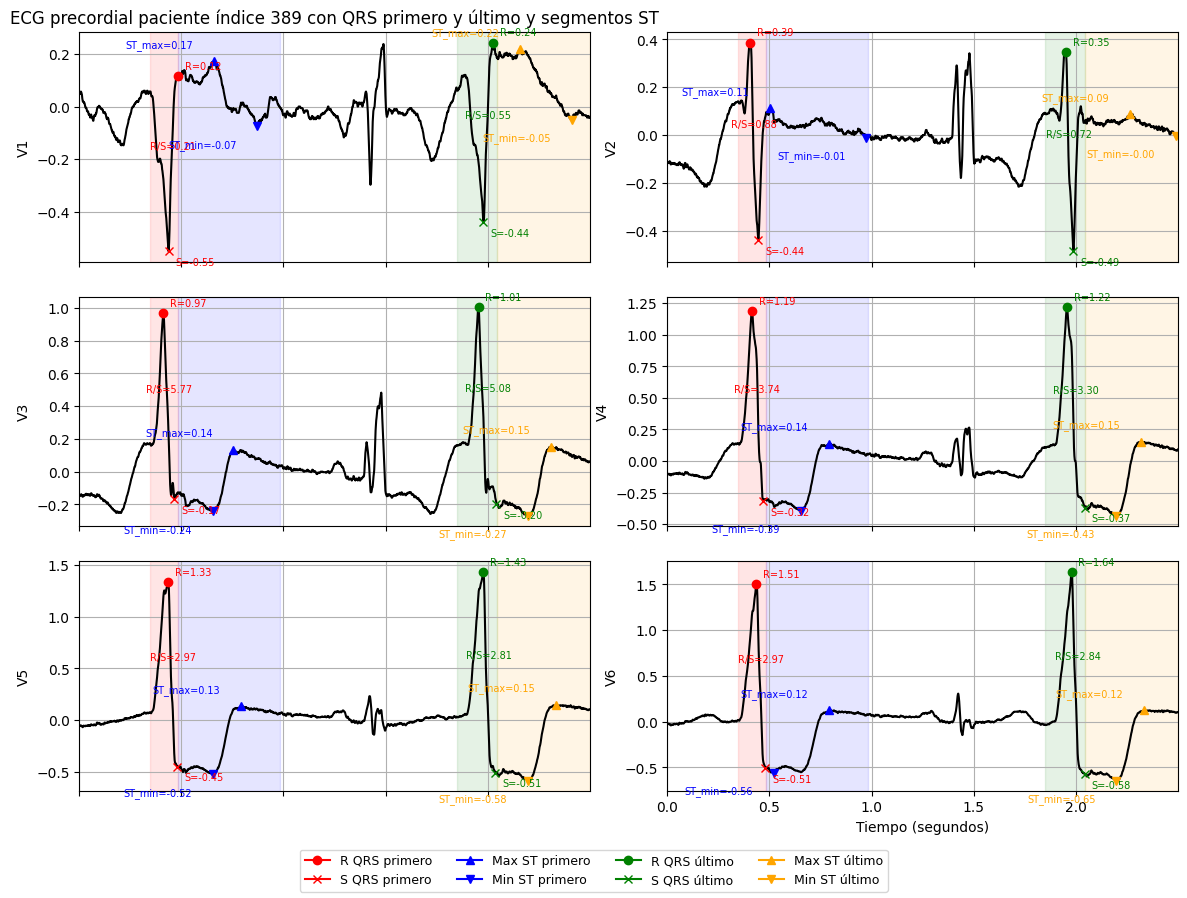

In [ ]:
# Obtener índices de pacientes con origen LVOT
lvot_indices = df.index[df['origin_label'] == 1].tolist()

print(f"Number of LVOT patients: {len(lvot_indices)}")
print(f"First 5 LVOT index {lvot_indices[:5]}")

# Por ejemplo, usar el décimo para visualizar (índice 9)
patient_idx_to_plot = lvot_indices[9]

# Visualizar con la función adaptada para dos QRS
plot_ecg_precordial_with_two_qrs_and_st(df, segmentaciones2, patient_idx_to_plot)


origin_label Patient_ID  RVOT_count  LVOT_count
0                  P003         355           0
1                  P027           0         114
2                  P031          18           0
3                  P033          42           0
4                  P034         753           0


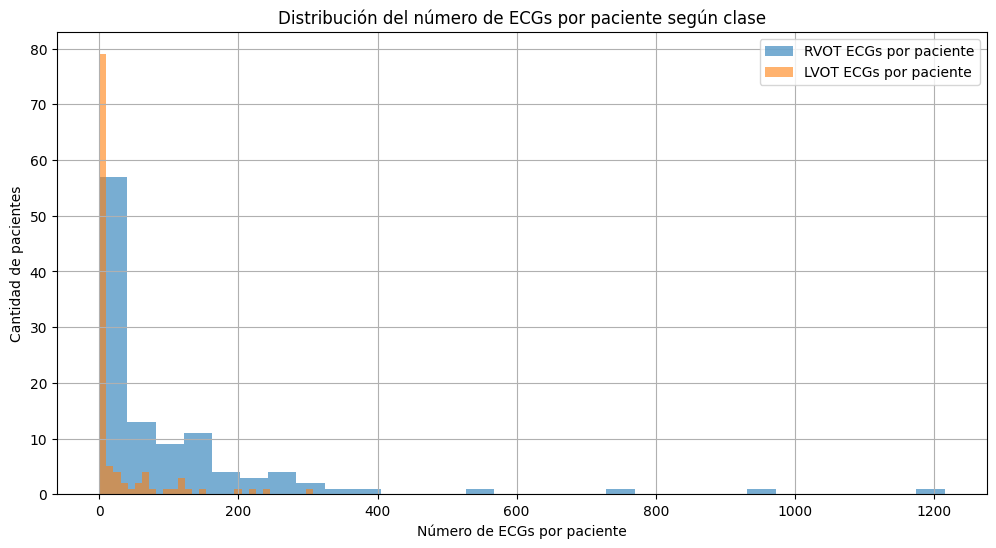

In [ ]:
summary_df = full_df.groupby(['Patient_ID', 'origin_label']).size().unstack(fill_value=0)
summary_df = summary_df.rename(columns={0: 'RVOT_count', 1: 'LVOT_count'})
summary_df = summary_df.reset_index()
print(summary_df.head())

# Histogram
plt.figure(figsize=(12, 6))
plt.hist(summary_df['RVOT_count'], bins=30, alpha=0.6, label='RVOT ECGs per patient')
plt.hist(summary_df['LVOT_count'], bins=30, alpha=0.6, label='LVOT ECGs per patient')
plt.xlabel('Número de ECGs por paciente')
plt.ylabel('Cantidad de pacientes')
plt.title('Distribución del número de ECGs por paciente según clase')
plt.legend()
plt.grid(True)
plt.show()


# LEFT AND RIGHT CLASSIFICATION

This first model is with the ecgs limited to 400 ecgs per patient

Rows after deleating NaNs: (13717, 68)
After limiting ECGs to a maximum of 1400 per patient: (13717, 68)
origin_label
0    78
1    31
Name: Patient_ID, dtype: int64
Data to train: (13717, 66), labels: (13717,)

=== Results (threshold = 0.3) ===
Accuracy: 0.834

              precision    recall  f1-score   support

        RVOT      0.893     0.904     0.899     11177
        LVOT      0.554     0.523     0.538      2540

    accuracy                          0.834     13717
   macro avg      0.723     0.714     0.718     13717
weighted avg      0.830     0.834     0.832     13717



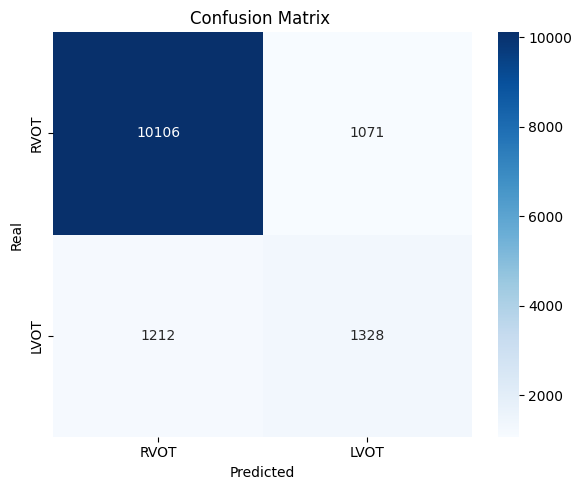

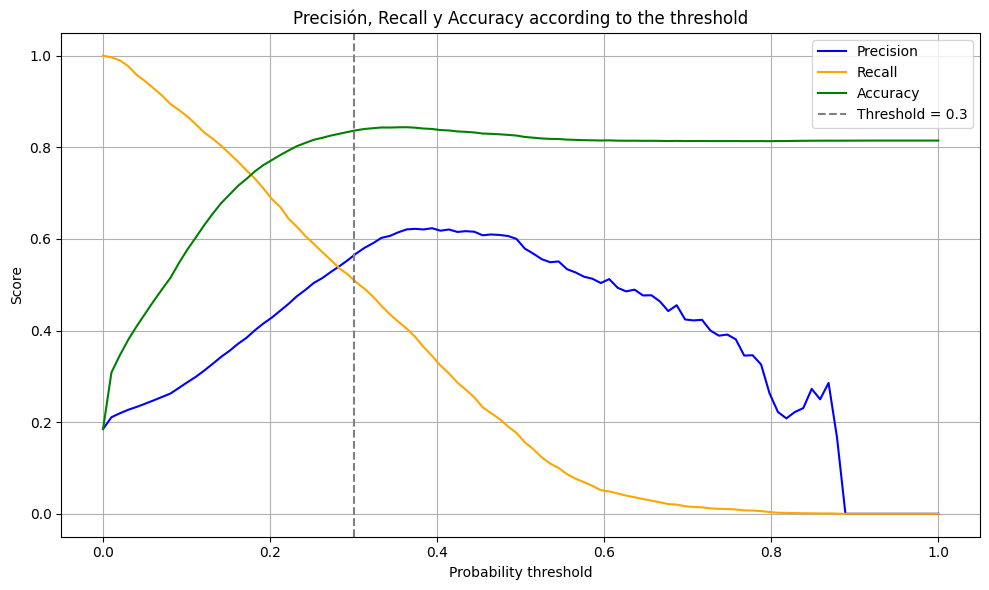

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)
import seaborn as sns

max_ecgs_per_patient = 1400
threshold = 0.3

# 1. Limpiar NaNs
mask_no_nan = ~full_df.drop(columns=['Patient_ID', 'origin_label']).isna().any(axis=1)
df_clean = full_df.loc[mask_no_nan].reset_index(drop=True)
print(f"Rows after deleating NaNs: {df_clean.shape}")

# 2. Limitar ECGs por paciente
filtered_dfs = []
for patient in df_clean['Patient_ID'].unique():
    patient_df = df_clean[df_clean['Patient_ID'] == patient]
    if len(patient_df) > max_ecgs_per_patient:
        patient_df = patient_df.sample(n=max_ecgs_per_patient, random_state=42)
    filtered_dfs.append(patient_df)
df_balanced = pd.concat(filtered_dfs).reset_index(drop=True)
print(f"After limiting ECGs to a maximum of {max_ecgs_per_patient} per patient: {df_balanced.shape}")
print(df_balanced.groupby('origin_label')['Patient_ID'].nunique())

# 3. Preparar datos
X = df_balanced.drop(columns=['Patient_ID', 'origin_label']).copy()
y = df_balanced['origin_label'].astype(int).copy()
groups = df_balanced['Patient_ID'].copy()
print(f"Data to train: {X.shape}, labels: {y.shape}")

# 4. Entrenamiento y obtención de probabilidades
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight={0: 1, 1: 5})
gkf = GroupKFold(n_splits=5)
y_probs = cross_val_predict(rf, X, y, groups=groups, cv=gkf, method="predict_proba")[:, 1]

# 5. Aplicar umbral personalizado
y_pred = (y_probs >= threshold).astype(int)

# 6. Evaluación
acc = accuracy_score(y, y_pred)
report = classification_report(y, y_pred, target_names=['RVOT', 'LVOT'], digits=3)
cm = confusion_matrix(y, y_pred)

print(f"\n=== Results (threshold = {threshold}) ===")
print(f"Accuracy: {acc:.3f}\n")
print(report)

# 7. Matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['RVOT', 'LVOT'], yticklabels=['RVOT', 'LVOT'])
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title(f'Confusion Matrix ')
plt.tight_layout()
plt.show()

# 8. Gráfico de precisión, recall y accuracy según threshold
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
accuracies = []

for t in thresholds:
    y_th = (y_probs >= t).astype(int)
    precisions.append(precision_score(y, y_th, zero_division=0))
    recalls.append(recall_score(y, y_th))
    accuracies.append(accuracy_score(y, y_th))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.plot(thresholds, accuracies, label='Accuracy', color='green')
plt.axvline(threshold, color='gray', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Probability threshold')
plt.ylabel('Score')
plt.title('Precisión, Recall y Accuracy according to the threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

               Feature  Importance
10  deriv1_mean_V2_pvc    0.077933
13   deriv2_std_V2_pvc    0.056079
61                 bmi    0.046938
16        ratio_V3_pvc    0.044265
11   deriv1_std_V2_pvc    0.041145
17  deriv1_mean_V3_pvc    0.038752
49      delta_S_min_V3    0.028242
46      delta_R_max_V2    0.027786
14        R_max_V3_pvc    0.027363
42  R_amplitude_DI_pvc    0.026690
24  deriv1_mean_V4_pvc    0.026316
6    deriv2_std_V1_pvc    0.026139
59                 sex    0.024763
15        S_min_V3_pvc    0.021737
60                 hta    0.021238


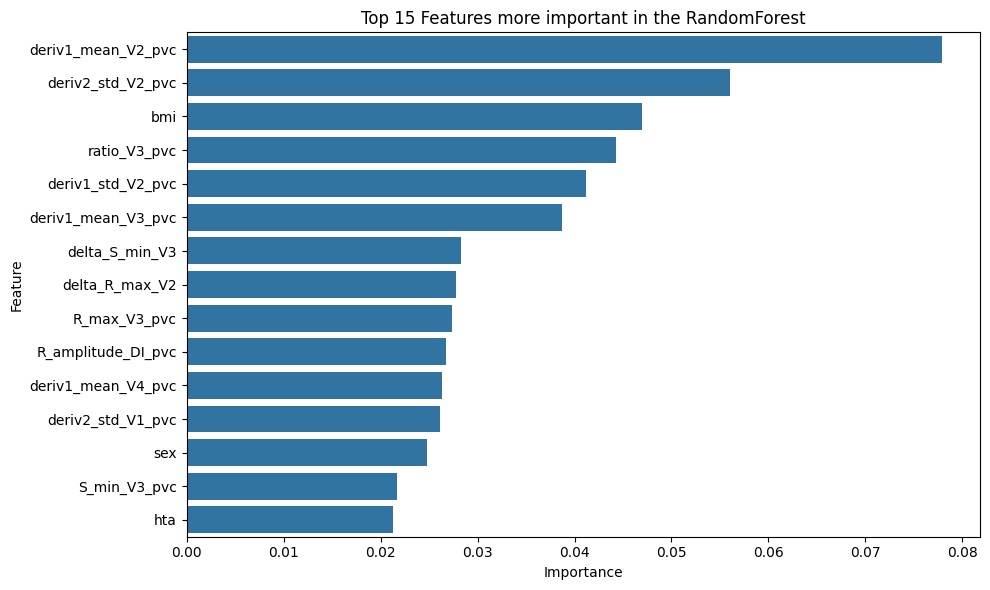

In [29]:
importances = None
feature_names = X.columns

# Entrenar RandomForest con todo el dataset para extraer importancias
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced')
rf.fit(X, y)

importances = rf.feature_importances_

# Crear DataFrame con las importancias y ordenar
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Mostrar las 15 features más importantes
print(feat_importances.head(15))

# Graficar importancias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances.head(15))
plt.title('Top 15 Features more important in the RandomForest')
plt.tight_layout()
plt.show()


In [ ]:
# Mostrar cantidad total de pacientes únicos y ECGs totales en full_df
total_pacientes = full_df['Patient_ID'].nunique()
total_ecgs = full_df.shape[0]

print(f"Total pacientes únicos: {total_pacientes}")
print(f"Total ECGs en el dataset: {total_ecgs}")

# RVOTSEPTUM AND COMMISSURE FEATURE EXTRACTION

In [ ]:
list(df.columns)

In [ ]:
target_classes = ['COMMISURE', 'RVOTSEPTUM']

# Filtrar índices de pacientes con esas etiquetas
indices_target = df[df['Simplified'].isin(target_classes)].index.tolist()

# Filtrar segmentaciones para quedarte solo con esos índices
segmentaciones_filtradas = [seg for seg in segmentaciones2 if seg['idx'] in indices_target]

print(f"Segmentaciones filtradas: {len(segmentaciones_filtradas)}")


In [ ]:
lead_V1 = 6
lead_V2 = 7
lead_V3 = 8
lead_DII = 1
lead_DIII = 2
lead_indices = [6, 7, 8, 9, 10, 11]

patient_ids = []
transition_rs_list = []
rs_v1_list = []
rs_v2_list = []
angle_rs_v1_list = []
angle_rs_v2_list = []
r_gt_1mv_v3_list = []
s_v2_div_r_v3_list = []
rs_dii_list = []
rii_r_iii_ratio_list = []

# Para guardar valores del primer QRS para calcular deltas
transition_rs_first = []
rs_v1_first = []
rs_v2_first = []
angle_rs_v1_first = []
angle_rs_v2_first = []

for s in segmentaciones_filtradas:
    idx = s["idx"]

    if idx not in df.index:
        continue

    row = df.loc[idx]
    ecg = row["ecg"]
    intervals = s["intervals"]

    if len(intervals) < 2:
        # Saltar si no hay dos intervalos
        continue

    patient_ids.append(row["patient"])

    # Procesar el último QRS (PVC)
    start_last, end_last = intervals[-1]
    seg_v1 = ecg[lead_V1][start_last:end_last]
    seg_v2 = ecg[lead_V2][start_last:end_last]
    seg_v3 = ecg[lead_V3][start_last:end_last]
    seg_dii = ecg[lead_DII][start_last:end_last]
    seg_diii = ecg[lead_DIII][start_last:end_last]

    r1 = seg_v1.max()
    s1 = seg_v1.min()
    rs_v1_list.append(abs(r1 / s1) if s1 != 0 else np.nan)
    angle_rs_v1_list.append(np.arctan(r1 / abs(s1)) if s1 != 0 else np.nan)

    r2 = seg_v2.max()
    s2 = seg_v2.min()
    rs_v2_list.append(abs(r2 / s2) if s2 != 0 else np.nan)
    angle_rs_v2_list.append(np.arctan(r2 / abs(s2)) if s2 != 0 else np.nan)

    r_gt_1mv_v3_list.append(int(seg_v3.max() > 1.0))
    s = seg_v2.min()
    r = seg_v3.max()
    s_v2_div_r_v3_list.append(abs(s / r) if r not in [None, 0] and s is not None else np.nan)

    r_dii = seg_dii.max()
    s_dii = seg_dii.min()
    rs_dii_list.append(abs(r_dii / s_dii) if s_dii != 0 else np.nan)

    r_ii = seg_dii.max()
    r_iii = seg_diii.max()
    rii_r_iii_ratio_list.append(r_ii / r_iii if r_iii != 0 else np.nan)

    # Transición R/S en precordiales para el último QRS
    rs_ratios_last = []
    for i in lead_indices:
        seg = ecg[i][start_last:end_last]
        r = seg[np.argmax(seg)]
        s = seg[np.argmin(seg)]
        rs_ratios_last.append(abs(r / s) if s != 0 else np.nan)

    def find_rs_transition(rs_ratios):
        for i, ratio in enumerate(rs_ratios):
            if ratio >= 1:
                return i
        return np.nan

    transition_rs_list.append(find_rs_transition(rs_ratios_last))

    # Procesar el primer QRS para diferencias
    start_first, end_first = intervals[0]
    seg_v1_f = ecg[lead_V1][start_first:end_first]
    seg_v2_f = ecg[lead_V2][start_first:end_first]

    r1_f = seg_v1_f.max()
    s1_f = seg_v1_f.min()
    rs_v1_first.append(abs(r1_f / s1_f) if s1_f != 0 else np.nan)
    angle_rs_v1_first.append(np.arctan(r1_f / abs(s1_f)) if s1_f != 0 else np.nan)

    r2_f = seg_v2_f.max()
    s2_f = seg_v2_f.min()
    rs_v2_first.append(abs(r2_f / s2_f) if s2_f != 0 else np.nan)
    angle_rs_v2_first.append(np.arctan(r2_f / abs(s2_f)) if s2_f != 0 else np.nan)

    rs_first = []
    for i in lead_indices:
        seg = ecg[i][start_first:end_first]
        r = seg[np.argmax(seg)]
        s = seg[np.argmin(seg)]
        rs_first.append(abs(r / s) if s != 0 else np.nan)
    transition_rs_first.append(find_rs_transition(rs_first))

# Construcción del DataFrame con features
X_features_rvot = pd.DataFrame({
    "Patient_ID": patient_ids,
    "Transition_RS": transition_rs_list,
    "R/S_V1": rs_v1_list,
    "R/S_V2": rs_v2_list,
    "R_greater_1mV_V3": r_gt_1mv_v3_list,
    "S_V2_div_R_V3": s_v2_div_r_v3_list,
    "R/S_DII": rs_dii_list,
    "RII_div_RIII": rii_r_iii_ratio_list,
    "Angle_RS_V1": angle_rs_v1_list,
    "Angle_RS_V2": angle_rs_v2_list,
})

# Calcular las diferencias entre first y last para las features numéricas seleccionadas
X_features_rvot["delta_Transition_RS"] = np.array(transition_rs_list) - np.array(transition_rs_first)
X_features_rvot["delta_R/S_V2"] = np.array(rs_v2_list) - np.array(rs_v2_first)
X_features_rvot["delta_Angle_RS_V1"] = np.array(angle_rs_v1_list) - np.array(angle_rs_v1_first)
X_features_rvot["delta_Angle_RS_V2"] = np.array(angle_rs_v2_list) - np.array(angle_rs_v2_first)

# Asignar etiquetas Simplified según Patient_ID (que ahora es el id real)
idx_to_simplified = df.set_index("patient")["Simplified"].to_dict()
X_features_rvot["Simplified"] = X_features_rvot["Patient_ID"].map(idx_to_simplified)

print(X_features_rvot.head(10))


In [ ]:
meta_cols = [
    "patient", "sex", "hta", "smoker", "copd", "sleep_apnea"
]

meta_df = (
    df[meta_cols]
    .drop_duplicates(subset="patient")
    .rename(columns={"patient": "Patient_ID"})
)

# Aseguramos formato string con prefijo 'P' para evitar inconsistencias
X_features_rvot["Patient_ID"] = X_features_rvot["Patient_ID"].astype(str).apply(lambda x: x if x.startswith('P') else 'P' + x)
meta_df["Patient_ID"] = meta_df["Patient_ID"].astype(str).apply(lambda x: x if x.startswith('P') else 'P' + x)

# Merge con metadata
full_df = X_features_rvot.merge(meta_df, on="Patient_ID", how="left")

print("Full dataframe shape:", full_df.shape)
missing = full_df.isna().sum()
print("NaNs por columna en full_df:\n", missing[missing > 0])

rows_with_nan = full_df.isna().any(axis=1).sum()
print(f"Filas con al menos un NaN en full_df: {rows_with_nan}")


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA

max_ecgs_per_patient = 1400

# 1. Eliminar filas con NaNs en las features ECG (excepto columnas no predictoras)
mask_no_nan = ~full_df.drop(columns=['Patient_ID', 'Simplified']).isna().any(axis=1)
df_clean = full_df.loc[mask_no_nan].reset_index(drop=True)
print(f"Filas tras eliminar NaNs: {df_clean.shape}")

# 2. Limitar ECGs por paciente
filtered_dfs = []
for patient in df_clean['Patient_ID'].unique():
    patient_df = df_clean[df_clean['Patient_ID'] == patient]
    if len(patient_df) > max_ecgs_per_patient:
        patient_df = patient_df.sample(n=max_ecgs_per_patient, random_state=42)
    filtered_dfs.append(patient_df)
df_balanced = pd.concat(filtered_dfs).reset_index(drop=True)
print(f"Después de limitar ECGs a máximo {max_ecgs_per_patient} por paciente: {df_balanced.shape}")

# 3. Preparar variables
X = df_balanced.drop(columns=['Patient_ID', 'Simplified'])
y = df_balanced['Simplified'].map({'RVOTSEPTUM': 0, 'COMMISURE': 1}).astype(int)
groups = df_balanced['Patient_ID']

# Después de preparar X e y, y antes del entrenamiento:

# 1. Normalizar las features para PCA (opcional pero recomendado)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 3. Visualizar con scatter plot
plt.figure(figsize=(8,6))
for label, color in zip([0,1], ['blue', 'orange']):
    plt.scatter(X_pca[y==label, 0], X_pca[y==label, 1], label=("RVOTSEPTUM" if label==0 else "COMMISURE"), alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Proyección PCA de las features ECG")
plt.legend()
plt.grid(True)
plt.show()


# 4. Inicializar modelo y validación cruzada
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
gkf = GroupKFold(n_splits=5)

# 5. Cross-validation: obtener probabilidades
y_probs = cross_val_predict(rf, X, y, cv=gkf, groups=groups, method="predict_proba")[:, 1]

# 6. Ajustar threshold para convertir probabilidades en etiquetas
threshold = 0.28  # Cambia aquí el umbral que quieras usar
y_pred_thresh = (y_probs >= threshold).astype(int)

# 7. Evaluación
acc = accuracy_score(y, y_pred_thresh)
cm = confusion_matrix(y, y_pred_thresh)
report = classification_report(y, y_pred_thresh, target_names=["RVOTSEPTUM", "COMMISURE"])


print(f"Accuracy: {acc:.2f}\n")
print(report)

# 8. Matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["RVOTSEPTUM", "COMMISURE"],
            yticklabels=["RVOTSEPTUM", "COMMISURE"])
plt.title(f"Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 9. Visualización precisión vs recall
precision, recall, thresholds = precision_recall_curve(y, y_probs)
plt.plot(thresholds, precision[:-1], label="Precisión")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precisión y Recall según el threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 1. Preparar datos para entrenar modelo final
X_final = df_balanced.drop(columns=['Patient_ID', 'Simplified'])
y_final = df_balanced['Simplified'].map({'RVOTSEPTUM': 0, 'COMMISURE': 1}).astype(int)

# 2. Entrenar modelo Random Forest completo
rf_final = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_final.fit(X_final, y_final)

# 3. Obtener importancias de features
importances = rf_final.feature_importances_
feature_names = X_final.columns

# 4. Crear DataFrame para visualizar
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 5. Mostrar las top 20 features
print(feat_imp_df.head(20))

# 6. Graficar importancias top 20
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df.head(20)['feature'], feat_imp_df.head(20)['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Top 20 Features más importantes (Random Forest)')
plt.tight_layout()
plt.show()


In [ ]:
# Agrupar por paciente y contar ECGs
counts = df.groupby('patient').size().reset_index(name='num_ecgs')

# Añadir etiqueta Simplified (es igual para todos los ECGs de un paciente)
patient_simplified = df.drop_duplicates('patient')[['patient', 'Simplified']]

counts = counts.merge(patient_simplified, on='patient')

# Filtrar solo etiquetas COMMISURE y RVOTSEPTUM
target_classes = ['COMMISURE', 'RVOTSEPTUM']
counts = counts[counts['Simplified'].isin(target_classes)]

# Ordenar por número de ECGs para mejor visualización
counts = counts.sort_values('num_ecgs', ascending=False)

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=counts, x='patient', y='num_ecgs', hue='Simplified', dodge=False)

plt.xticks(rotation=90)
plt.xlabel('Paciente')
plt.ylabel('Número de ECGs')
plt.title('Número de ECGs por paciente y etiqueta Simplified (COMMISURE y RVOTSEPTUM)')
plt.legend(title='Etiqueta')
plt.tight_layout()
plt.show()
